## Step-01: Loading the Dataset

In [2]:
import pandas as pd

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

### In the previous task, we examined the dataset and found no missing values

In [3]:
# Converting SignupDate and TransactionDate to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merging datasets to create a comprehensive view
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

                     TransactionDate     Quantity   TotalValue     Price_x  \
count                           1000  1000.000000  1000.000000  1000.00000   
mean   2024-06-23 15:33:02.768999936     2.537000   689.995560   272.55407   
min              2023-12-30 15:29:12     1.000000    16.080000    16.08000   
25%       2024-03-25 22:05:34.500000     2.000000   295.295000   147.95000   
50%       2024-06-26 17:21:52.500000     3.000000   588.880000   299.93000   
75%              2024-09-19 14:19:57     4.000000  1011.660000   404.40000   
max              2024-12-28 11:00:00     4.000000  1991.040000   497.76000   
std                              NaN     1.117981   493.144478   140.73639   

                          SignupDate     Price_y  
count                           1000  1000.00000  
mean   2023-07-09 02:49:55.199999744   272.55407  
min              2022-01-22 00:00:00    16.08000  
25%              2022-09-17 12:00:00   147.95000  
50%              2023-07-23 00:00:00   299

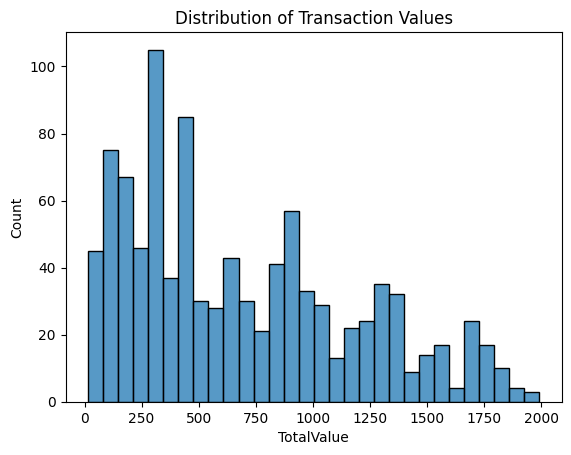

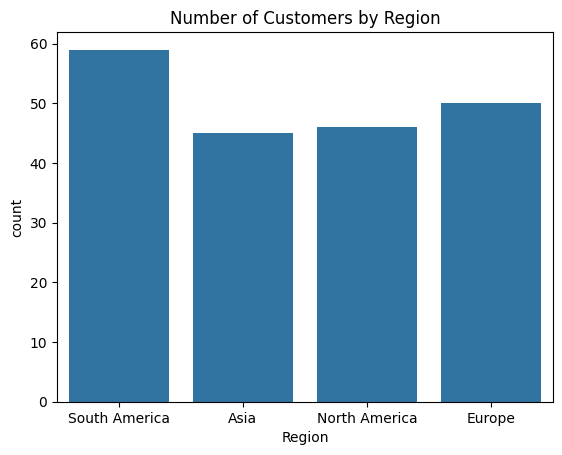

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary
print(merged_data.describe())

# Visualizing the distribution of transaction values
sns.histplot(merged_data['TotalValue'], bins=30)
plt.title('Distribution of Transaction Values')
plt.show()

# Count of transactions by region
sns.countplot(data=customers, x='Region')
plt.title('Number of Customers by Region')
plt.show()

## Step-02: Feature Engineering

In [5]:
# Create a customer profile
customer_profile = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'ProductID': lambda x: x.nunique(),
    'SignupDate': 'min'
}).reset_index()

customer_profile.columns = ['CustomerID', 'TotalSpend', 'TransactionCount', 'UniqueProducts', 'SignupDate']

## Step-03: Calculating Similarity Scores

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Standardizing the features
features = customer_profile[['TotalSpend', 'TransactionCount', 'UniqueProducts']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Calculating cosine similarity
similarity_matrix = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile['CustomerID'], columns=customer_profile['CustomerID'])

## Step-04: Generating Lookalike recommendations

In [8]:
# Initializing a list to store the lookalike recommendations
lookalike_recommendations = []

# Loop through the first 20 customers
for customer in customer_profile['CustomerID'][:20]:
    # Getting the similarity scores for the current customer
    scores = similarity_df[customer].sort_values(ascending=False)
    
    # Getting the top 3 lookalikes (excluding the customer themselves)
    top_lookalikes = scores.index[1:4]  # Excluding the first one as it's the customer itself
    top_scores = scores.values[1:4]
    
    # Adding the results to the list
    for lookalike, score in zip(top_lookalikes, top_scores):
        lookalike_recommendations.append({
            'CustomerID': customer,
            'LookalikeID': lookalike,
            'SimilarityScore': score
        })

# Converting the list to a DataFrame
lookalike_df = pd.DataFrame(lookalike_recommendations)

# Saving the DataFrame to a CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)